# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

Данные геологоразведки трёх регионов: 

geo_data_0

geo_data_1

geo_data_2

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек;

product — объём запасов в скважине (тыс. баррелей).

Цель:

Выяснить, в каких регионах вероятность убытков меньше 2,5%. 

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from numpy.random import RandomState
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.3f}'.format) 


In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [3]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [4]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
# Выведем общую информацию о датасете
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


In [7]:
# Выведем общую информацию о датасете
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


In [9]:
# Выведем общую информацию о датасете
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


In [11]:
# Проверим пропуски
print(data_0.isna().sum())
print(data_1.isna().sum())
data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
print(data_0.duplicated().sum())
print(data_1.duplicated().sum())
data_2.duplicated().sum()

0
0


0

Исследуем корреляцию между признаками

In [13]:
cm = sns.light_palette("pink", as_cmap=True)

data_0.corr().style.background_gradient(cmap=cm)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [28]:
data_1.corr().style.background_gradient(cmap=cm)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Очень сильная корреляция между f1 и product в 1 регионе

In [29]:
data_2.corr().style.background_gradient(cmap=cm)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


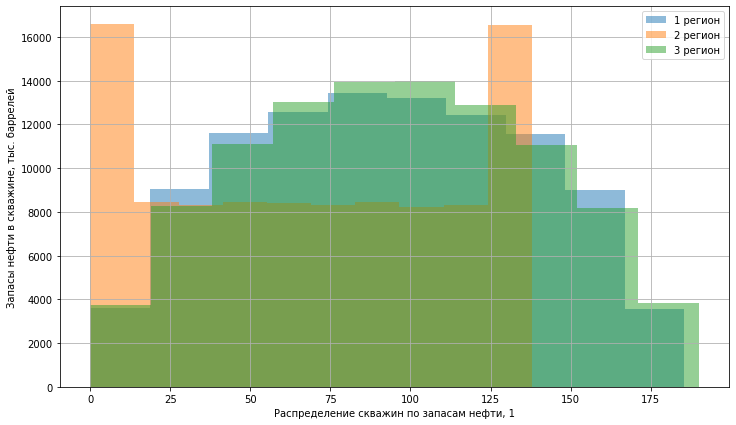

In [30]:
pr0 = data_0['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='1 регион');
pr1 = data_1['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='2 регион');
pr2 = data_2['product'].plot(kind='hist',
                             figsize=(12,7),
                             grid=True,
                             legend=True,
                             alpha=0.5,
                             label='3 регион');
plt.xlabel('Распределение скважин по запасам нефти, 1');
plt.ylabel('Запасы нефти в скважине, тыс. баррелей');

Вывод:

Данные загружены и проверены на наличие дубликатов и пропусков. Дубликаты и пропуски отсутствуют.

Все признаки в датасетах численные, категориальных признаков нет.

Столбец id не должен участвовать в обучении модели, в дальнейшем в выборке участвовать не будет. 

В датасетах по 100 к объектов - достаточно для исследования.

Исходя из исследований корреляции - в первом регионе прямая зависимость, сильная корреляция между f2 и product.
Для двух других датасетов эта зависимость на уровне 0.4 и 0.5 - умеренная линейная зависимость. 

## Обучение и проверка модели

In [14]:
target_0 = data_0['product']
features_0 = data_0.drop(['id','product'], axis=1)

# разделяем обучающую выборку на обучающую и валидационную (75/25)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, 
                                                                              target_0, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [15]:
model = LinearRegression()
model.fit(features_train_0, target_train_0)
predictions_valid_0 = model.predict(features_valid_0)

result_0 = mean_squared_error(target_valid_0, predictions_valid_0)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_0)

predictions_mean_0 = round(predictions_valid_0.mean(),0)
print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions_valid_0.mean()))

RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
Средний запас предсказанного сырья: 92.59 тыс. баррелей.


In [16]:
target_1 = data_1['product']
features_1 = data_1.drop(['id','product'], axis=1)

# разделяем обучающую выборку на обучающую и валидационную (75/25)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, 
                                                                              target_1, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [17]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predictions_valid_1 = model.predict(features_valid_1)

result_1 = mean_squared_error(target_valid_1, predictions_valid_1)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_1)

predictions_mean_1 = round(predictions_valid_1.mean(),0)
print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions_valid_1.mean()))

RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617
Средний запас предсказанного сырья: 68.73 тыс. баррелей.


In [18]:
target_2 = data_2['product']
features_2 = data_2.drop(['id','product'], axis=1)

# разделяем обучающую выборку на обучающую и валидационную (75/25)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, 
                                                                              target_2, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

In [19]:
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predictions_valid_2 = model.predict(features_valid_2)

result_2 = mean_squared_error(target_valid_2, predictions_valid_2)**0.5 
print("RMSE модели линейной регрессии на валидационной выборке:", result_2)

predictions_mean_2 = round(predictions_valid_2.mean(),0)
print("Средний запас предсказанного сырья: {0:.2f} тыс. баррелей.". \
          format(predictions_valid_2.mean()))

RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434
Средний запас предсказанного сырья: 94.97 тыс. баррелей.


Промежуточный вывод:

Разделены все данные на обучающую и валидационную выборки в соотношении 75:25.

Созданы и обучены модели с помощью Линейной регрессии.

Выполнены предсказания на валидационной выборке

Сделаны предсказания по объёму сырья в скважинах.

Рассчитаны значения среднего запаса предсказанного сырья и RMSE моделей:

Для нулевого региона и второго региона RMSE модели = 37.58 и RMSE = 39.96. Значения очень большие по сравнению с средним запасом предсказанного сырья. Это говорит о том, что присутствует сильный разброс данных в валидационных выборках датасетов.
Для первого региона RMSE модели = 0.89. Такие низкие значения могут быть связаны с переобучением модели. 
В первом регионе самые низкие запасы предсказанного сырья - 69 тыс баррелей, когда в двух других регионах - 93 - 95 баррелей

## Подготовка к расчёту прибыли

In [20]:
# При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
NUMBER_POINTS = 500  
NUMBER_BEST_POINTS = 200    
# Бюджет на разработку скважин в регионе — 10 млрд рублей. Обозначим константу в тыс. рублей
BUDGET = 1e07 
# Доход с каждой единицы продукта
COST_1_BARREL = 450  
# Количество выборок для метода Bootstrap
NUMBER_SAMPLE_BOOTSTRAP = 1000 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [21]:
print("Точка безубыточности: {0:.0f} тыс. баррелей на каждый регион.\n". \
      format(BUDGET / COST_1_BARREL))
print("Средний объем нефти в скважине, требуемый для безубыточной работы: {0:.0f} тыс. баррелей.". \
      format(BUDGET / COST_1_BARREL / NUMBER_BEST_POINTS))

Точка безубыточности: 22222 тыс. баррелей на каждый регион.

Средний объем нефти в скважине, требуемый для безубыточной работы: 111 тыс. баррелей.


Промежуточный вывод:

Среднее значение запаса сырья по всем скважинам для каждого из регионов меньше, чем объем для сырья для безубыточной разработки новой скважины: 111 тыс. баррелей. Все скважины бурить нерентабельно, нужно выбрать 200 лучших из них.


## Расчёт прибыли и рисков 

In [22]:
def profit(target_valid, predictions_valid):
    target = target_valid.reset_index(drop = True)
    predictions = pd.Series(predictions_valid, index = target.index)
    best_points = target[predictions.sort_values(ascending = False).index][:NUMBER_BEST_POINTS]

    return (best_points.sum() * COST_1_BARREL - BUDGET) / 1000

sum_bar_0 = predictions_valid_0[:200].sum()
sum_bar_1 = predictions_valid_1[:200].sum()
sum_bar_2 = predictions_valid_2[:200].sum()

print('Объем нефти в 0 регионе равен %.0f' % sum_bar_0, 'тыс. баррелей')
print('Объем нефти в 1 регионе равен %.0f' % sum_bar_1, 'тыс. баррелей')
print('Объем нефти в 2 регионе равен %.0f' % sum_bar_2, 'тыс. баррелей')


Объем нефти в 0 регионе равен 18260 тыс. баррелей
Объем нефти в 1 регионе равен 13346 тыс. баррелей
Объем нефти в 2 регионе равен 19644 тыс. баррелей


In [23]:
profit_0 = profit(target_valid_0, predictions_valid_0)
profit_1 = profit(target_valid_1, predictions_valid_1)
profit_2 = profit(target_valid_2, predictions_valid_2)
print('Прибыль с 0 региона равна %.2f' % profit_0, 'млн. руб.')
print('Прибыль с 1 региона равна %.2f' % profit_1, 'млн. руб.')
print('Прибыль с 2 региона равна %.2f' % profit_2, 'млн. руб.')

Прибыль с 0 региона равна 3320.83 млн. руб.
Прибыль с 1 региона равна 2415.09 млн. руб.
Прибыль с 2 региона равна 2710.35 млн. руб.


Промежуточные результаты:

Все три региона потенциально прибыльные.
Для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка проведём расчёт вероятности.

In [24]:
def bootstrap1000(target, predict):
    state = np.random.RandomState(12345)
    n = 500
    profits = []
    count = 0

    for i in range(1000):
        target_subsample = target.reset_index(drop= True).sample(n, random_state=state, replace=True)
        probs_subsample = predict[target_subsample.index]
        
        profits.append(profit(target_subsample,
                              probs_subsample))
    profits = pd.Series(profits)
    
    count = profits[profits<0].count()/1000

    lower = profits.quantile(0.025)
    upper = profits.quantile(.975)

    print('Средняя прибыль в регионе равна: %.2f' % (profits.mean()), 'млн. руб.')
    print('95% доверительный интервал лежит в диапазоне: {:.2f}'.format(lower),
          '- {:.2f}'.format(upper))
    print('Вероятность убытка равна: {:.2%}'.format(count))

In [25]:
# нулевой регион
bootstrap1000(target_valid_0, predictions_valid_0)

Средняя прибыль в регионе равна: 396.16 млн. руб.
95% доверительный интервал лежит в диапазоне: -111.22 - 909.77
Вероятность убытка равна: 6.90%


In [26]:
# первый регион
bootstrap1000(target_valid_1, predictions_valid_1)

Средняя прибыль в регионе равна: 456.05 млн. руб.
95% доверительный интервал лежит в диапазоне: 33.82 - 852.29
Вероятность убытка равна: 1.50%


In [27]:
# второй регион
bootstrap1000(target_valid_2, predictions_valid_2)

Средняя прибыль в регионе равна: 404.40 млн. руб.
95% доверительный интервал лежит в диапазоне: -163.35 - 950.36
Вероятность убытка равна: 7.60%


Вывод:
Были подготовлены данные. Проверены на наличие дубликатов, пропусков.
Разбили данные на обучающую и валидационную выборку в отношении 75/25. Обучены с помощью линейной регрессии.
Рассчитано среднеквадратичное отклонение предсказаний от валидационной выборки.
Сравнили средний объем нефти в регионе с достаточным объёмом сырья для безубыточной разработки новой скважины. Оказалось, что средний объем нефти в каждом регионе ниже достаточного объема - 111 тыс. баррелей.
Процедурой Bootstrap разбили выборки по 500 значений, взяли 200 с наибольшим показателем объема в скважине с помощью сортировки. Расчитали прибыль/убыток.
Расчитали среднюю прибыль в регионе, доверительный интервал и вероятность убытка.
Наиболее рентабельно вложить бюджет в развитие добычи нефти в 1 регионе, так как там самая низкая вероятность убытки и самая высокая средняя прибыль.